## Temperature trend: Missing data and Regression

- The aim of the task is to determine the long-term temperature trend in Wernigerode by means of a regression.
- This workbook uses the data set for the Wernigerode weather station from the Open Data Library of the German Weather Service: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_05490_19470101_20221231_hist.zip . 
- The description of the dataset: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/DESCRIPTION_obsgermany_climate_daily_kl_historical_en.pdf
- Analyse the usability of the data using an explorative data analysis.
- Train a model of your choice to replace the missing measured values (-999.) with meaningful values.
- Perform a **linear regression** on the completed data set and determineÖ
    - the temperature trend with the variable ('TMK'),
    - and $R^2$.

### Other resources:
- https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/


In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [30]:
df = pd.read_csv(r"tageswerte_KL_05490_19470101_20221231_hist\produkt_klima_tag_19470101_20221231_05490.txt",sep = ";")
df

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,5490,19470101,-999,-999.0,-999.0,5,-999.0,-999,-999.000,-999,-999.0,5.1,987.20,-5.2,89.00,-2.4,-8.6,-10.4,eor
1,5490,19470102,-999,-999.0,-999.0,5,-999.0,-999,-999.000,-999,-999.0,6.5,991.80,-1.9,97.00,-0.6,-8.2,-9.5,eor
2,5490,19470103,-999,-999.0,-999.0,5,-999.0,-999,-999.000,-999,-999.0,5.9,1000.00,-3.8,95.00,-0.4,-4.0,-8.0,eor
3,5490,19470104,-999,-999.0,-999.0,5,-999.0,-999,-999.000,-999,-999.0,3.3,1004.20,-9.9,82.00,-4.0,-11.0,-14.0,eor
4,5490,19470105,-999,-999.0,-999.0,5,-999.0,-999,-999.000,-999,-999.0,2.1,997.90,-14.8,84.00,-10.6,-16.0,-17.4,eor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27741,5490,20221227,3,17.8,5.6,3,0.4,6,2.000,0,5.2,6.0,993.73,4.5,71.46,5.5,3.3,1.1,eor
27742,5490,20221228,3,17.2,5.4,3,0.9,6,0.000,0,7.7,7.5,984.37,6.6,76.33,8.5,3.9,3.0,eor
27743,5490,20221229,3,17.6,5.6,3,3.1,6,0.833,0,6.5,8.5,977.18,9.7,70.92,11.6,7.7,5.7,eor
27744,5490,20221230,3,18.9,5.9,3,1.8,6,0.733,0,5.7,7.4,981.30,7.5,71.04,11.7,5.7,2.6,eor


In [31]:
df = df.where(df != -999,np.nan)
df.isna().sum()

STATIONS_ID        0
MESS_DATUM         0
QN_3            5037
  FX           11821
  FM            5231
QN_4              60
 RSK            1945
RSKF            1944
 SDK            6007
SHK_TAG        13281
  NM           11826
 VPM             565
  PM            4396
 TMK             425
 UPM             569
 TXK             397
 TNK             398
 TGK            5347
eor                0
dtype: int64

## Clean dataframe

In [32]:
df.columns #clean up the name of columns (no space)
df.columns = ['STATIONS_ID', 'MESS_DATUM', 'QN_3', 'FX', 'FM', 'QN_4', 'RSK',
       'RSKF', 'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM',
       'TXK', 'TNK', 'TGK', 'eor']

### Date

In [33]:
dateTempMiss = np.array(df.MESS_DATUM)
#mess_datum column is integer
dateTempMiss = dateTempMiss.astype(str)
year = []
month= []
date = []
for i in range(len(dateTempMiss)):
    dateObject = datetime.datetime.strptime(dateTempMiss[i],'%Y%m%d') #transform to a date time object
    getYear = dateObject.year
    getMonth = dateObject.month
    getDate = dateObject.day
    year.append(getYear)
    month.append(getMonth)
    date.append(getDate)
df['Year'] = year
df['Month'] = month
df['Date'] = date

In [34]:
df.columns

Index(['STATIONS_ID', 'MESS_DATUM', 'QN_3', 'FX', 'FM', 'QN_4', 'RSK', 'RSKF',
       'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM', 'TXK', 'TNK', 'TGK',
       'eor', 'Year', 'Month', 'Date'],
      dtype='object')

### Standardize the data
Standardize all numeric variabls except for temperature because we want to predict temperature later on.

In [71]:
scaler = StandardScaler() 
data = df[['FX','FM','RSK','RSKF','SDK','SHK_TAG','NM','VPM', 'PM', 'UPM', 'TXK', 'TNK', 'TGK', 'TMK']]
scaler.fit(data)
std_data = pd.DataFrame(scaler.transform(data))
std_data.columns = ['FX','FM','std_RSK','RSKF','SDK','SHK_TAG','NM','VPM', 'PM', 'UPM', 'TXK', 'TNK', 'TGK','std_TMK']
data1= df[['STATIONS_ID', 'MESS_DATUM','Year', 'Month', 'Date','TMK', 'RSK']]
std_df = pd.concat([data1, std_data], axis=1)
std_df
#std_data[:,0] to get the column that we want

,STATIONS_ID,MESS_DATUM,Year,Month,Date,TMK,RSK,FX,FM,std_RSK,...,SDK,SHK_TAG,NM,VPM,PM,UPM,TXK,TNK,TGK,std_TMK
0,5490,19470101,1947,1,1,-5.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.061902,-0.002714,1.301729,-1.823242,-1.958857,-1.957000,-1.904589
1,5490,19470102,1947,1,2,-1.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.690478,0.514662,2.017523,-1.611250,-1.900516,-1.825684,-1.461638
2,5490,19470103,1947,1,3,-3.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.849660,1.436940,1.838574,-1.587695,-1.287932,-1.606823,-1.716671
3,5490,19470104,1947,1,4,-9.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.539448,1.909327,0.675408,-2.011679,-2.308906,-2.482266,-2.535458
4,5490,19470105,1947,1,5,-14.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.857812,1.200747,0.854357,-2.788983,-3.038173,-2.978350,-3.193173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27741,5490,20221227,2022,12,27,4.5,0.4,1.032201,0.974060,-0.295142,...,-0.611943,-0.263182,-0.223293,-0.823129,0.731735,-0.267651,-0.892833,-0.223201,-0.279069,-0.602583
27742,5490,20221228,2022,12,28,6.6,0.9,0.921828,0.881798,-0.175238,...,-1.101831,-0.263182,0.944889,-0.425174,-0.321012,0.168089,-0.539513,-0.135689,-0.001846,-0.320705
27743,5490,20221229,2022,12,29,9.7,3.1,0.995410,0.974060,0.352338,...,-0.897792,-0.263182,0.384162,-0.159871,-1.129693,-0.315967,-0.174416,0.418554,0.392103,0.095400
27744,5490,20221230,2022,12,30,7.5,1.8,1.234552,1.112454,0.040588,...,-0.922287,-0.263182,0.010343,-0.451705,-0.666305,-0.305230,-0.162639,0.126847,-0.060209,-0.199900


## Trend in temperature

We will try to plot the temperature TMK.

Treat missings as NA --> ignore 

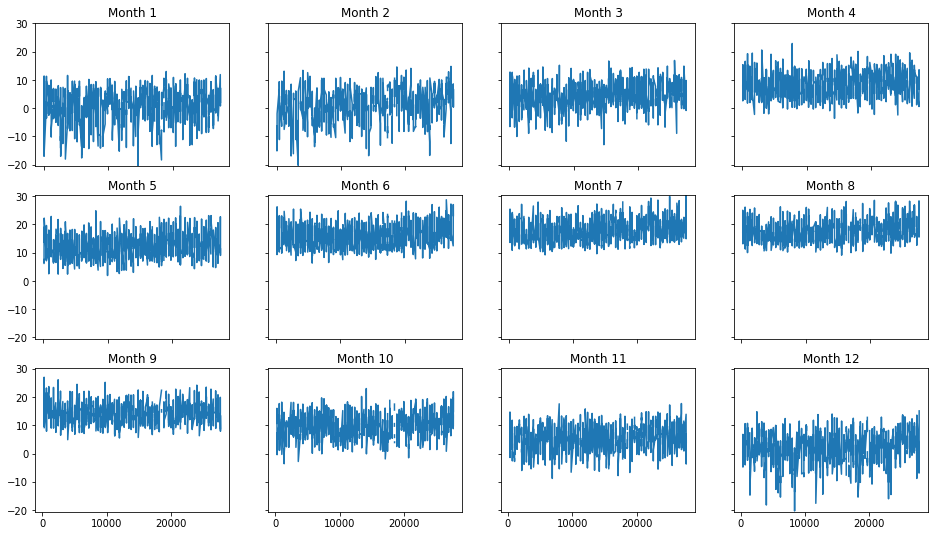

In [36]:
fig, axs = plt.subplots(3, 4,figsize=(16,9))
month_counter = 1
for j in range(3):
    for i in range(4):
        axs[j, i].plot(df.TMK[df.Month == month_counter])
        axs[j, i].set_title(f'Month {month_counter}')
        axs[j, i].set_ylim(df.TMK.min(), df.TMK.max())
        month_counter += 1

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#plt.title('Temparature trend for each month from 1947 to 2022')
#plt.scatter(temp.MESS_DATUM, temp.TMK, s= 0.5, label='NaN values') # we see, temp is between 20 and -2 

Each graph has too many points, which makes them hard to read. We plot another graph, where one point represent the mean temperature of a month in one year. 

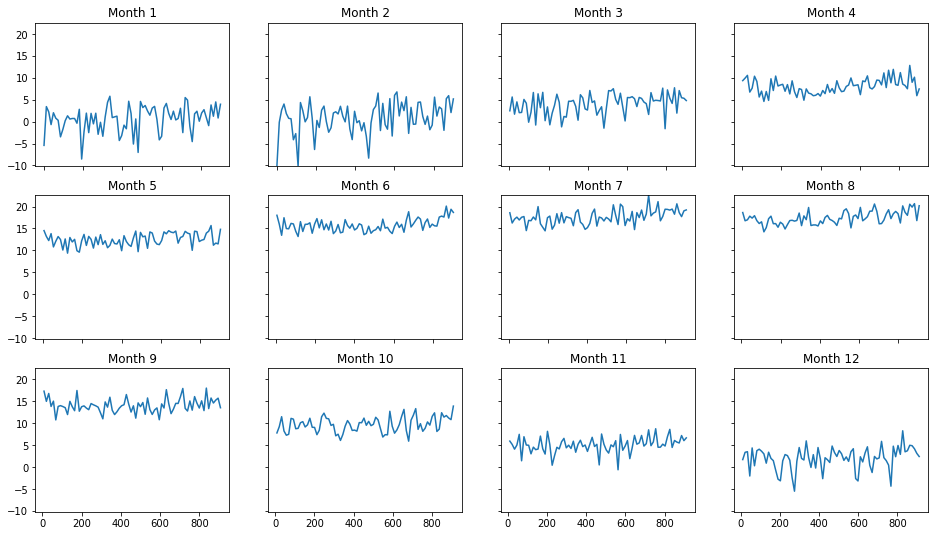

In [37]:
temp_df = df[['TMK', 'Year','Month']]
mean_temp_df = temp_df.groupby(by = ['Year','Month']).mean()
mean_temp_df= mean_temp_df.reset_index()
fig, axs = plt.subplots(3, 4,figsize=(16,9))
month_counter = 1
for j in range(3):
    for i in range(4):
        axs[j, i].plot(mean_temp_df.TMK[mean_temp_df.Month == month_counter])
        axs[j, i].set_title(f'Month {month_counter}')
        axs[j, i].set_ylim(mean_temp_df.TMK.min(), mean_temp_df.TMK.max())
        month_counter += 1

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Decompose data trend seasonality

Rely on the graph itself, we cannot say if there is a trend or not. Let's try decompose data trend seasonality: Additive model
- y(t) = Level + Trend + Seasonality + Noise

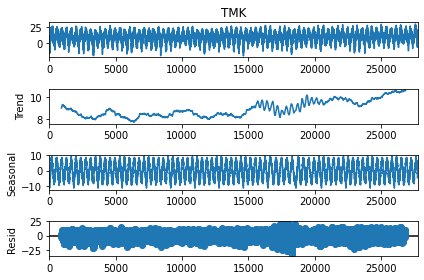

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.TMK[df['TMK'].notna()], model='additive', period = 365*5) # 5 years for each window of moving average 
#mean_temp_df.TMK, period = 1
result.plot()
#plt.title('Decompose trend, seasonality of temperature')
plt.show()

Trend is calculated by centered moving average of the time series (in this case 5 years). trend = TMK.rolling(window=365*5, center=True).mean()

Looking at trend we see that there might be an increase of 2 degrees.

We only have missings between 08.1991 and 10.2006. Maybe we can decompose seasonal trend from beginning 1947 to 07.1991, and 11.2006 to 12.2022


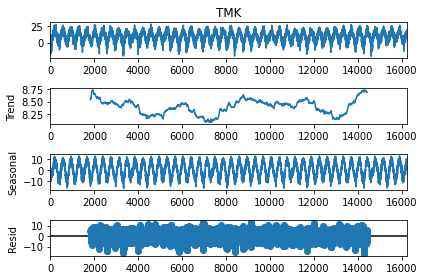

In [39]:
result = seasonal_decompose(df.TMK[df.MESS_DATUM<19910701], model='additive', period = 365*10) # 10 years for each window of moving average 
result.plot()
#plt.title('Decompose trend, seasonality of temperature')
plt.show()

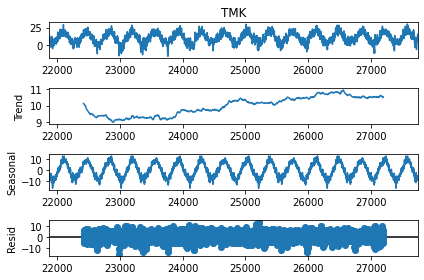

In [40]:
result = seasonal_decompose(df.TMK[df.MESS_DATUM > 20061130], model='additive', period = 365*3) # 10 years for each window of moving average 
result.plot()
#plt.title('Decompose trend, seasonality of temperature')
plt.show()

Clearly from 12.2006 to 12.2022 there is an upward trend in temperature.

In [41]:
#pd.set_option("display.max_rows", None)
pd.reset_option('max_rows')
df[['Year','Month','Date','TMK','SDK','NM','TGK']][df.TMK.isna()]
#whenever temperature TMK is missing, it is very likely that other variables are also missing--> hard to use linear regression

,Year,Month,Date,TMK,SDK,NM,TGK
16296,1991,8,14,NaN,NaN,NaN,5.5
16297,1991,8,15,NaN,NaN,NaN,NaN
16298,1991,8,16,NaN,NaN,NaN,NaN
16299,1991,8,17,NaN,NaN,NaN,NaN
16300,1991,8,18,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
21544,2006,1,8,NaN,0.0,NaN,NaN
21545,2006,1,9,NaN,6.6,NaN,NaN
21644,2006,4,18,NaN,4.3,NaN,NaN
21645,2006,4,19,NaN,4.3,NaN,NaN


## Imputation 

Whenever temperature TMK is missing, it is very likely that other variables are also missing--> hard to use linear regression. 
Before interpolating or imputing the missing values, we want to check if whether the variable varies a lot or not. Ideally, the variable has only a few missings and does not have high variance. 

### An overview over the distribution of all variables 

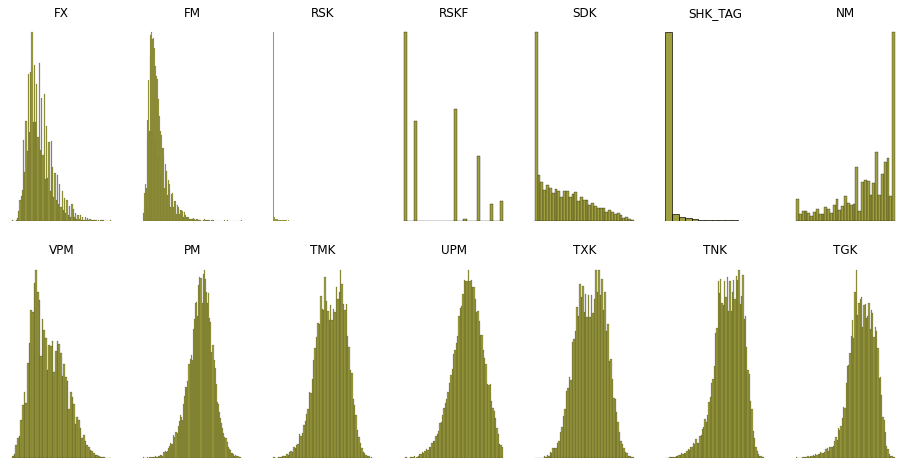

In [42]:
counter = 7
# Create subplots 
f, axes = plt.subplots(2, counter, figsize=(16, 8))
cols = ['FX', 'FM', 'RSK', 'RSKF','SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM', 'TXK', 'TNK', 'TGK']
# Plot Histogram plot with total_bill column

for i in range(len(cols)): #goes from 0 to 13
    if (i<counter):
        sns.histplot( df[cols[i]] , color="olive", ax=axes[0,i])  
        axes[0, i].set_title(cols[i])
    elif (i >=counter):
        sns.histplot( df[cols[i]] , color="olive", ax=axes[1,i-counter])
        axes[1, i-counter].set_title(cols[i])
        
for ax in axes.flat:
    ax.set_axis_off()
    #ax.spines['left'].set_visible(False)

Since the variables on the 2nd row do not vary too much, we can interpolate/ impute the missing values. Temperature (TMK) is also interpolatable or imputable. 

### Missing values

<Axes: >

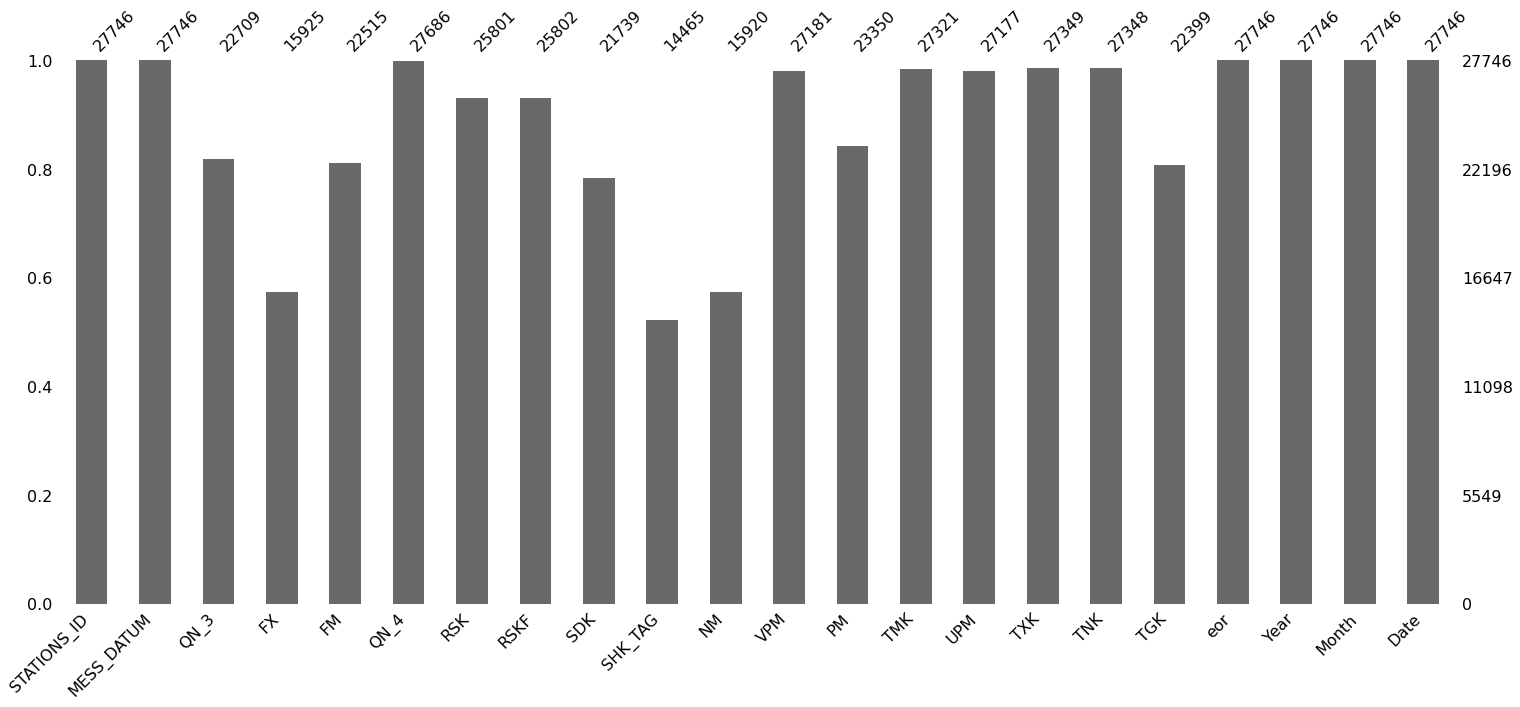

In [43]:
import missingno as msno
msno.bar(df)

The bar chart shows how many missings each variable has compare to one another. We have 3 variables like FX, SHK_TAG, NM that have a lot of missings. To see the positions of missings, we have a matrix plot.

<Axes: >

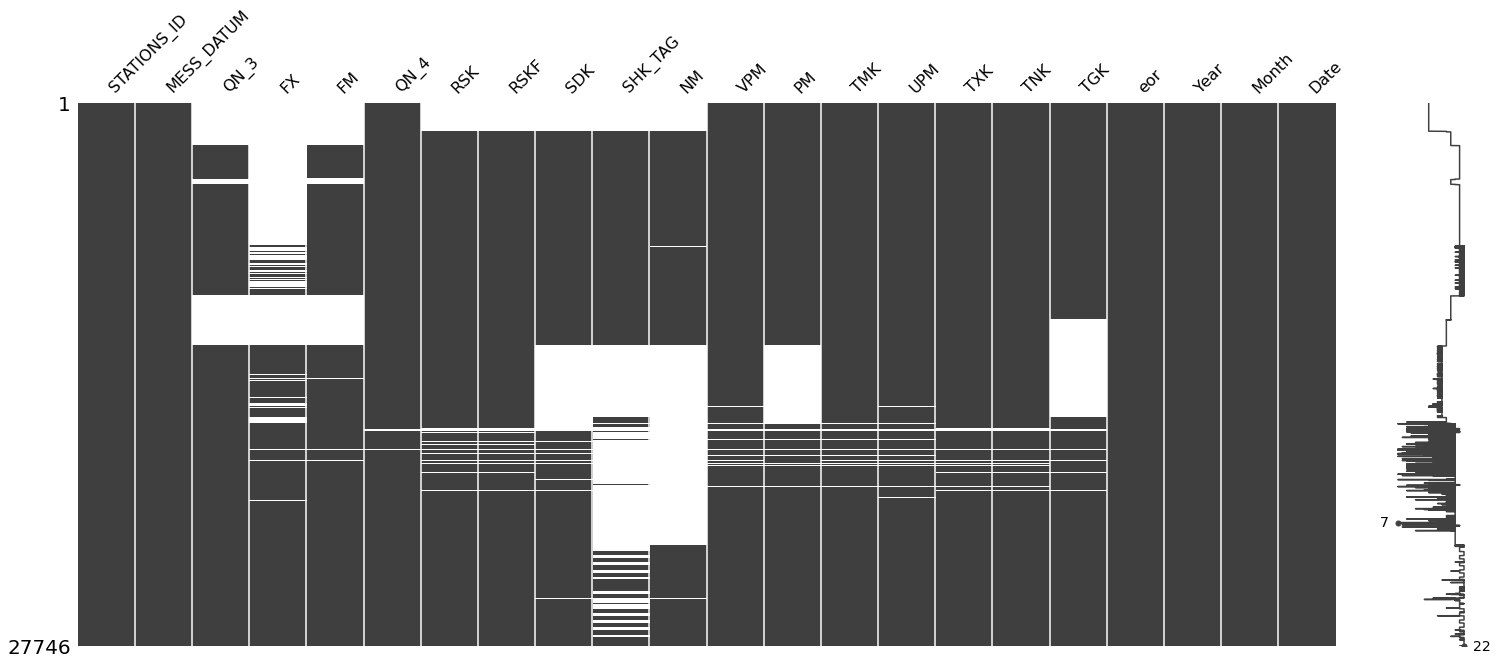

In [44]:
msno.matrix(df)

Out of 3 variables FX, SHK_TAG, NM mentioned above, FX has many missings at the beginning of the recorded period, while SHK_TAG and NM have missings mainly at the end of the period. When analyse these variables, we have to keep this in mind. From the 2 graphs, I would choose RSK, RSKF, VPM, UPM, TXK, TNK to predict temperature.


<Axes: >

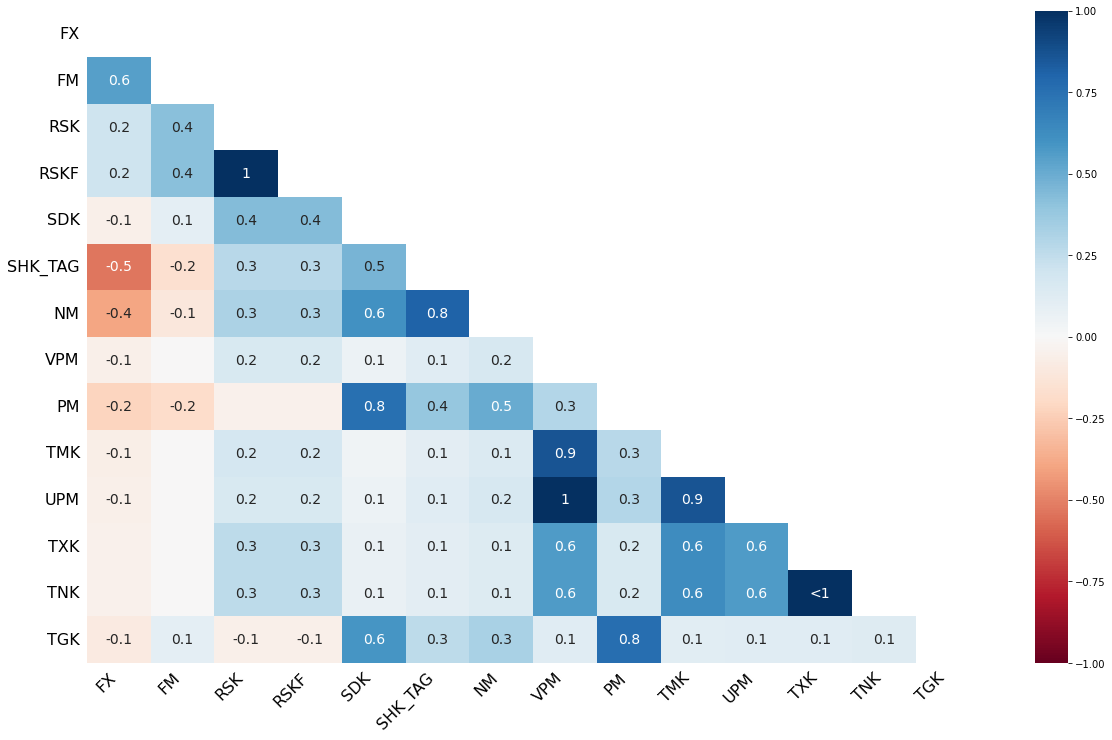

In [45]:
msno.heatmap(df.drop(columns=['QN_3','QN_4']))

- -1 means: A missing value in feature A implies that there is not a missing value in feature B.
- 1 means: A missing value in feature A implies that there is also a missing value in feature B.

Exp: When there are missings in temparature, it is likely that UPM, VPM. 

--> From the heat map, we can use 'FX', 'FM', 'RSK', 'RSKF', 'SDK', 'SHK_TAG', 'NM','PM', 'TGK' to predict the missing values of temperature

In [46]:
std_df

,STATIONS_ID,MESS_DATUM,Year,Month,Date,TMK,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,UPM,TXK,TNK,TGK
0,5490,19470101,1947,1,1,-5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.061902,-0.002714,1.301729,-1.823242,-1.958857,-1.957000
1,5490,19470102,1947,1,2,-1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.690478,0.514662,2.017523,-1.611250,-1.900516,-1.825684
2,5490,19470103,1947,1,3,-3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.849660,1.436940,1.838574,-1.587695,-1.287932,-1.606823
3,5490,19470104,1947,1,4,-9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.539448,1.909327,0.675408,-2.011679,-2.308906,-2.482266
4,5490,19470105,1947,1,5,-14.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.857812,1.200747,0.854357,-2.788983,-3.038173,-2.978350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27741,5490,20221227,2022,12,27,4.5,1.032201,0.974060,-0.295142,1.375874,-0.611943,-0.263182,-0.223293,-0.823129,0.731735,-0.267651,-0.892833,-0.223201,-0.279069
27742,5490,20221228,2022,12,28,6.6,0.921828,0.881798,-0.175238,1.375874,-1.101831,-0.263182,0.944889,-0.425174,-0.321012,0.168089,-0.539513,-0.135689,-0.001846
27743,5490,20221229,2022,12,29,9.7,0.995410,0.974060,0.352338,1.375874,-0.897792,-0.263182,0.384162,-0.159871,-1.129693,-0.315967,-0.174416,0.418554,0.392103
27744,5490,20221230,2022,12,30,7.5,1.234552,1.112454,0.040588,1.375874,-0.922287,-0.263182,0.010343,-0.451705,-0.666305,-0.305230,-0.162639,0.126847,-0.060209


### Linear Regression

Looks like SDK and TGK are very important in this regression model.

<Axes: >

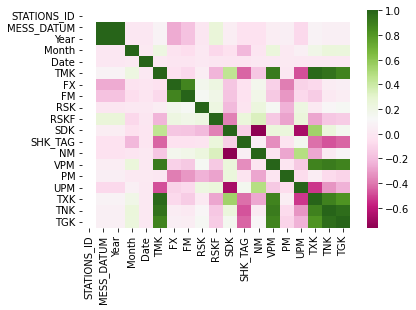

In [47]:
#Check for multicolinearity
corr_matrix = std_df.corr()
round(corr_matrix,2)
sns.heatmap(corr_matrix, cmap = 'PiYG')

In [48]:

#ordinary least square 
# X with shape (n sample, n features): SDK: daily sunshine duration, NM: cloud cover, TGK
#n_days is the distance between the current date and the beginning date of this dataset (19470101)
std_df['n_days'] = [i -19470101 for i in std_df.MESS_DATUM]
vars = ['n_days','TMK']
std_df_dropNA = std_df[vars].dropna(axis = 0, how = 'any') #drop row that has na
X = std_df_dropNA.drop(columns = ['TMK'])
y = std_df_dropNA.TMK

linReg_model = LinearRegression().fit(X,y)
print('R squared: ',linReg_model.score(X,y))
print('Coefficients: ',linReg_model.coef_)

R squared:  0.006519335332054399
Coefficients:  [2.72698645e-06]


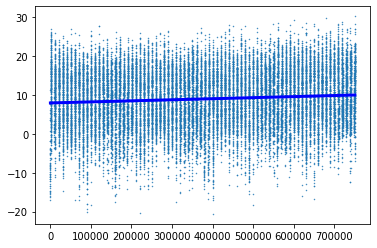

In [49]:
pred_y = linReg_model.predict(X)
#plt.scatter(std_df_dropNA.Year, std_df_dropNA.TMK,s = 0.1)
plt.scatter(std_df_dropNA.n_days, std_df_dropNA.TMK, s= 0.2)
plt.plot(std_df_dropNA.n_days, pred_y, color="blue", linewidth=3)
plt.show()

In [50]:
import statsmodels.api as sma
vars = ['Year','Month','Date','TMK']
std_df_dropNA = std_df[vars].dropna(axis = 0, how = 'any') #drop row that has na
X_multiple = std_df_dropNA.drop(columns = ['TMK'])
y = std_df_dropNA.TMK
X2  = sma.add_constant(X_multiple)
_1  = sma.OLS(y, X2)
_2  = _1.fit()
print(_2.summary())
linReg_model2 = LinearRegression().fit(X_multiple,y)
print('R squared: ',linReg_model2.score(X_multiple,y))
print('Coefficients: ',linReg_model2.coef_)

                            OLS Regression Results                            
Dep. Variable:                    TMK   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     528.8
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:32:29   Log-Likelihood:                -92862.
No. Observations:               27321   AIC:                         1.857e+05
Df Residuals:                   27317   BIC:                         1.858e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -48.2390      3.944    -12.231      0.0

R2 indicates that the model is not so good. Coefficient of year is positive and significant, which indicates a small increase of temperature from 1947 to 2022. The coefficient of month is much larger (p_value very small), because the temperature changes in different months (or season) are more visible.

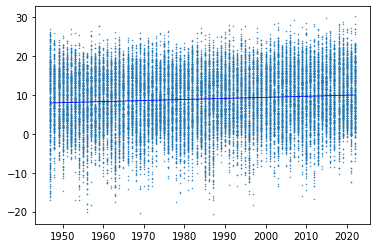

In [23]:
pred_y2 = linReg_model2.predict(X_multiple)
#plt.scatter(std_df_dropNA.Year, std_df_dropNA.TMK,s = 0.1)
plt.scatter(std_df_dropNA.Year, std_df_dropNA.TMK, s= 0.2)
plt.plot(std_df_dropNA.Year, pred_y, color="blue", linewidth=0.8)

plt.show()

### Regression with sin function

C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


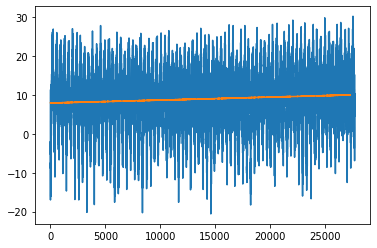

In [62]:
from scipy import stats
from scipy.optimize import curve_fit
#std_df['n_days'] = [i -19470101 for i in std_df.MESS_DATUM]
vars = ['MESS_DATUM','TMK']
data = std_df[vars].dropna(axis = 0, how = 'any') #drop row that has na
X = np.array(data.MESS_DATUM)
y = data.TMK

def linear_sinus_func(x, a, b, c, d, e):
    return a*x + b  + c * np.sin(2*np.pi + d*x + e)
#non linear least square fit
popt, pcov = curve_fit(linear_sinus_func, X, y, p0 = (0,0,10,365,1)) # p0 is the initial guess of the params
#popt is the Optimal values for the parameters so that the sum of the squared residuals are minimized
'''
print('Coefficients: ',withSin)
y_pred3 = linear_sinus_func(X, withSin[0], withSin[1], withSin[2],  withSin[3], withSin[4])
plt.scatter(X, y, s= 0.1)
plt.plot(X, y_pred3, color="blue", linewidth=0.8)
plt.show()
'''
plt.plot(y)
plt.plot(linear_sinus_func(X,*popt))
plt.show()

In [26]:
from sklearn.metrics import r2_score 
R_square = r2_score(y, y_pred3) 
print('R squared', R_square) 

R squared 0.00013548765555204678


look at residual histogramm, gaus looking?,then FFT on the residuals

R squared with the sin function is now much smaller, almost 0 (even negative if function is a*x + sin(x) + b). The best model out of 3 is the model that have year, month and date as independent variables.

### Predict missing temperature

In [26]:
missing_dates = np.array(df.MESS_DATUM[df.TMK.isna()])
missing_df = std_df[std_df['MESS_DATUM'].isin(missing_dates)]
missing_df

,STATIONS_ID,MESS_DATUM,Year,Month,Date,TMK,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,UPM,TXK,TNK,TGK,n_days
16296,5490,19910814,1991,8,14,NaN,NaN,NaN,NaN,NaN,NaN,-0.263182,NaN,NaN,NaN,NaN,NaN,NaN,0.362922,440713
16297,5490,19910815,1991,8,15,NaN,NaN,NaN,NaN,NaN,NaN,-0.263182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440714
16298,5490,19910816,1991,8,16,NaN,NaN,NaN,NaN,NaN,NaN,-0.263182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440715
16299,5490,19910817,1991,8,17,NaN,NaN,NaN,NaN,NaN,NaN,-0.263182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440716
16300,5490,19910818,1991,8,18,NaN,NaN,NaN,NaN,NaN,NaN,-0.263182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21544,5490,20060108,2006,1,8,NaN,NaN,NaN,NaN,NaN,-1.101831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590007
21545,5490,20060109,2006,1,9,NaN,NaN,NaN,NaN,NaN,0.514799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590008
21644,5490,20060418,2006,4,18,NaN,NaN,NaN,NaN,NaN,-0.048572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590317
21645,5490,20060419,2006,4,19,NaN,NaN,NaN,NaN,NaN,-0.048572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590318


In [27]:
X_test2= missing_df[['Year','Month','Date']]
pred_y2 = linReg_model2.predict(X_test2)
#plt.scatter(missing_df.Year, std_df_dropNA.TMK, s= 0.2)
#pd.DataFrame(data= np.array([X_test2,pred_y2]))
#np.stack((X_test2,pred_y2))
X_test2['pred_TMK'] = pred_y2
X_test2

C:\Users\ACER\AppData\Local\Temp\ipykernel_17664\1253907489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test2['pred_TMK'] = pred_y2


,Year,Month,Date,pred_TMK
16296,1991,8,14,9.878600
16297,1991,8,15,9.879589
16298,1991,8,16,9.880578
16299,1991,8,17,9.881567
16300,1991,8,18,9.882556
...,...,...,...,...
21544,2006,1,8,6.952204
21545,2006,1,9,6.953193
21644,2006,4,18,8.389040
21645,2006,4,19,8.390029


In [28]:
pred_y_withSin = linear_sinus_func(missing_dates, withSin[0], withSin[1], withSin[2])
prediction_withSin = pd.DataFrame(np.stack((missing_dates,pred_y_withSin), axis = 1))
prediction_withSin.columns = ['MESS_DATUM', 'TMK']
prediction_withSin.convert_dtypes()

,MESS_DATUM,TMK
0,19910814,9.007073
1,19910815,8.092694
2,19910816,7.841518
3,19910817,8.484478
4,19910818,9.430444
...,...,...
420,20060108,10.375082
421,20060109,9.516052
422,20060418,8.639382
423,20060419,8.728227


## Vorhersagen

In [51]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from scipy.stats import randint

Here we will use the data frame "data", which has only non NA MESS_DATUM and TMK. 27321 without NA: X_multiple (year, month, date) and y (TMK in original scale).

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_multiple, y, test_size=0.2)
model = RandomForestRegressor(random_state= 0, bootstrap=True, max_depth=2 ) #control the randomness of bootstrapping
model.fit(X_train, y_train)
y_pred_forest = model.predict(X_test)
accuracy_score = r2_score(y_test, y_pred_forest) 
print('Accuracy score:', accuracy_score) 

Accuracy score: 0.5474849937313309


We would try to add more variables to our forest regressor: RSK, RSKF, VPM, UPM, TXK and TNK. I have chosen them because they have only a few missings (for more see EDA for missings).

- RSK daily precipitation height mm NUMBER 9990.0
- RSKF precipitation form numerical code
- VPM daily mean of vapor pressure hPa NUMBER 9990.0
- UPM daily mean of relative humidity % NUMBER 9990.0
- TXK daily maximum of temperature at 2 m height
- TNK daily minimum of temperature at 2m


In [90]:
data2 = std_df[['RSK','RSKF','VPM','UPM','TXK','TNK','Year','Month','Date','TMK']].dropna(axis = 0, how = 'any')
X_multiple2 = data2.drop(columns=['TMK'])
y2 =data2.TMK
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_multiple2, y2, test_size=0.2)
model2 = RandomForestRegressor(random_state= 0, bootstrap=True, max_depth=2 ) #control the randomness of bootstrapping
model2.fit(X_train2, y_train2)
y_pred_forest2 = model2.predict(X_test2)
accuracy_score2 = r2_score(y_test2, y_pred_forest2) 
print('Accuracy score:', accuracy_score2) 

Accuracy score: 0.8677396036071989


Both accuracy scores are now much higher than regression model, although these scores are in a sense not the r2 value of regression.

Below is the table showing temperature (mean, max, min, and prediction on the 15th). Notice only predictions from model1 can be calculated because we don't have data (RSK, VPM,...) for the prediction of model 2.

In [92]:
toPredict_arr = []
for i in range(12):
    toPredict = [2023,i+1,15]
    toPredict_arr.append(toPredict)
middleMonth1 = pd.DataFrame(model.predict(toPredict_arr))

meanTMK = df[['TMK','Month']][df.MESS_DATUM>20100101].groupby(by = ['Month']).mean()
maxTMK = df[['TMK','Month']][df.MESS_DATUM>20100101].groupby(by = ['Month']).max()
minTMK = df[['TMK','Month']][df.MESS_DATUM>20100101].groupby(by = ['Month']).min()
summaryTMK = pd.concat([meanTMK, maxTMK, minTMK, middleMonth1], axis=1)
summaryTMK.columns = ['Mean','Max','Min','15th_of_Month prediction_date']
summaryTMK

C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,Mean,Max,Min,15th_of_Month prediction_date
1,1.442289,11.9,-12.9,4.258394
2,2.112262,14.8,-16.7,4.656190
3,4.961538,16.9,-8.9,8.805131
4,9.087436,19.6,-2.4,12.490800
5,12.974442,23.1,4.3,16.219884
6,17.262821,28.7,8.0,16.219884
7,18.951365,30.3,11.7,16.219884
8,18.769479,28.3,9.8,16.219884
9,14.680769,24.2,6.3,10.259914
10,10.805211,21.9,0.8,5.586918


The predicted temperatures for each month in 2023 on the 15th are plausible. These prediction are much better than the regression model (with and without sin function), where their predictions are mostly lie between 10 and 5.

The actual temperature: https://www.wetter.com/wetter_aktuell/rueckblick/deutschland/wernigerode/DE0011451.html?sid=10454&timeframe=30d
- Date (min - max temperature on the day)
- 15.03 (-1.6 - 5.8) --> prediction is high
- 15.04 (5.3 - 8.7) --> prediction is high
- 15.11 (7 - 9.9) --> prediction is low

The model trained only on dates are not so great.

### Predict rain 
Train gradient boosting tree on the the previous day to predict whether it would rain the next day or not

In [65]:
rain_cols = ['FX', 'FM','RSK', 'RSKF',
       'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM', 'TXK', 'TNK', 'TGK','Year', 'Month', 'Date']
rain_data = 

Index(['STATIONS_ID', 'MESS_DATUM', 'QN_3', 'FX', 'FM', 'QN_4', 'RSK', 'RSKF',
       'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM', 'TXK', 'TNK', 'TGK',
       'eor', 'Year', 'Month', 'Date'],
      dtype='object')

In [70]:
std_df

,STATIONS_ID,MESS_DATUM,Year,Month,Date,TMK,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,UPM,TXK,TNK,TGK,n_days
0,5490,19470101,1947,1,1,-5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.061902,-0.002714,1.301729,-1.823242,-1.958857,-1.957000,0
1,5490,19470102,1947,1,2,-1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.690478,0.514662,2.017523,-1.611250,-1.900516,-1.825684,1
2,5490,19470103,1947,1,3,-3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.849660,1.436940,1.838574,-1.587695,-1.287932,-1.606823,2
3,5490,19470104,1947,1,4,-9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.539448,1.909327,0.675408,-2.011679,-2.308906,-2.482266,3
4,5490,19470105,1947,1,5,-14.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.857812,1.200747,0.854357,-2.788983,-3.038173,-2.978350,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27741,5490,20221227,2022,12,27,4.5,1.032201,0.974060,-0.295142,1.375874,-0.611943,-0.263182,-0.223293,-0.823129,0.731735,-0.267651,-0.892833,-0.223201,-0.279069,751126
27742,5490,20221228,2022,12,28,6.6,0.921828,0.881798,-0.175238,1.375874,-1.101831,-0.263182,0.944889,-0.425174,-0.321012,0.168089,-0.539513,-0.135689,-0.001846,751127
27743,5490,20221229,2022,12,29,9.7,0.995410,0.974060,0.352338,1.375874,-0.897792,-0.263182,0.384162,-0.159871,-1.129693,-0.315967,-0.174416,0.418554,0.392103,751128
27744,5490,20221230,2022,12,30,7.5,1.234552,1.112454,0.040588,1.375874,-0.922287,-0.263182,0.010343,-0.451705,-0.666305,-0.305230,-0.162639,0.126847,-0.060209,751129


## Draft
(not to run)

In [40]:

#ordinary least square 
# X with shape (n sample, n features): SDK: daily sunshine duration, NM: cloud cover, TGK
vars = ['FM', 'RSK','SDK', 'SHK_TAG','PM', 'TGK','TMK']
transformed_df_dropNA = std_df[vars].dropna(axis = 0, how = 'any') #drop row that has na
X = transformed_df_dropNA[vars].drop(columns = ['TMK'])
y = transformed_df_dropNA.TMK

linReg_model = LinearRegression().fit(X,y)
print('R squared: ',linReg_model.score(X,y))
coeff = [round(i,2) for i in linReg_model.coef_]
print('Coefficients: \n',np.stack((vars[:-1], coeff), axis = 1))
#print('Coefficients: ', linReg_model.coef_)

R squared:  0.8620391122513702
Coefficients: 
 [['FM' '-0.06']
 ['RSK' '0.0']
 ['SDK' '0.3']
 ['SHK_TAG' '-0.05']
 ['PM' '-0.02']
 ['TGK' '0.78']]


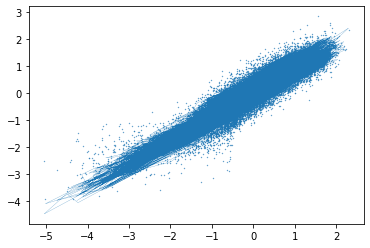

In [41]:
pred_y = linReg_model.predict(X)
plt.scatter(transformed_df_dropNA.TGK, transformed_df_dropNA.TMK,s = 0.1)
plt.plot(transformed_df_dropNA.TGK, pred_y, linewidth = 0.2)
plt.show()

### Values from other station

Our missings are from station Wernigerode, at the height of 233. We can take the measurements from Ilsenburg at the height of 260.           

In [17]:
df_Ilsenburg = pd.read_csv(r'D:\ACER\Documents\Master_Hochschule_Harz\2.Semester\Machine Learning\Abgabe\Abgabe 4\wetterMesswerteIlsenburg\produkt_klima_tag_19470101_19680731_02396.txt', sep = ';')
df_Ilsenburg


,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,2396,19470101,-999,-999,-999,5,-999.0,-999,-999.0,-999,-999.0,3.6,-999,-4.8,86.0,-1.9,-9.4,-999.0,eor
1,2396,19470102,-999,-999,-999,5,-999.0,-999,-999.0,-999,-999.0,4.8,-999,-2.8,94.0,0.6,-4.9,-999.0,eor
2,2396,19470103,-999,-999,-999,5,-999.0,-999,-999.0,-999,-999.0,4.1,-999,-4.4,93.0,-1.5,-5.4,-999.0,eor
3,2396,19470104,-999,-999,-999,5,-999.0,-999,-999.0,-999,-999.0,1.9,-999,-11.1,82.0,-3.7,-12.7,-999.0,eor
4,2396,19470105,-999,-999,-999,5,-999.0,-999,-999.0,-999,-999.0,1.5,-999,-14.1,75.0,-11.8,-17.2,-999.0,eor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7878,2396,19680727,-999,-999,-999,1,1.8,1,-999.0,0,-999.0,12.8,-999,14.3,77.0,19.9,8.9,7.4,eor
7879,2396,19680728,-999,-999,-999,1,0.0,0,-999.0,0,-999.0,12.8,-999,15.3,75.0,21.9,9.0,7.5,eor
7880,2396,19680729,-999,-999,-999,1,0.0,0,-999.0,0,-999.0,13.5,-999,16.4,71.0,22.8,10.8,9.2,eor
7881,2396,19680730,-999,-999,-999,1,0.0,0,-999.0,0,-999.0,13.7,-999,17.8,70.0,24.9,10.1,8.4,eor


In [34]:
#get only temperature from the days where there are missings
missing_dates = np.array(df.MESS_DATUM[df.TMK.isna()])
df_Ilsenburg[df_Ilsenburg['MESS_DATUM'].isin(missing_dates)]

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor


In [35]:
df_Ilsenburg[df_Ilsenburg.MESS_DATUM == 19910814]

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
